In [1]:
from qiskit import *
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram

In [2]:
#define unitary
def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)



In [3]:
#unitarity check 
np.allclose(U(1,1,1)@U(1,1,1).conj().T , np.identity(4),atol=1e-10)

True

In [4]:
#creation of controlled unitary
cu_gate = UnitaryGate(cu_matrix, label='CU') #this gate will have to be the whole evolution circuit 

# Apply the controlled unitary operation with control qubit 0 and target qubit 1
qc.append(cu_gate.control(), [0, 1])


NameError: name 'UnitaryGate' is not defined

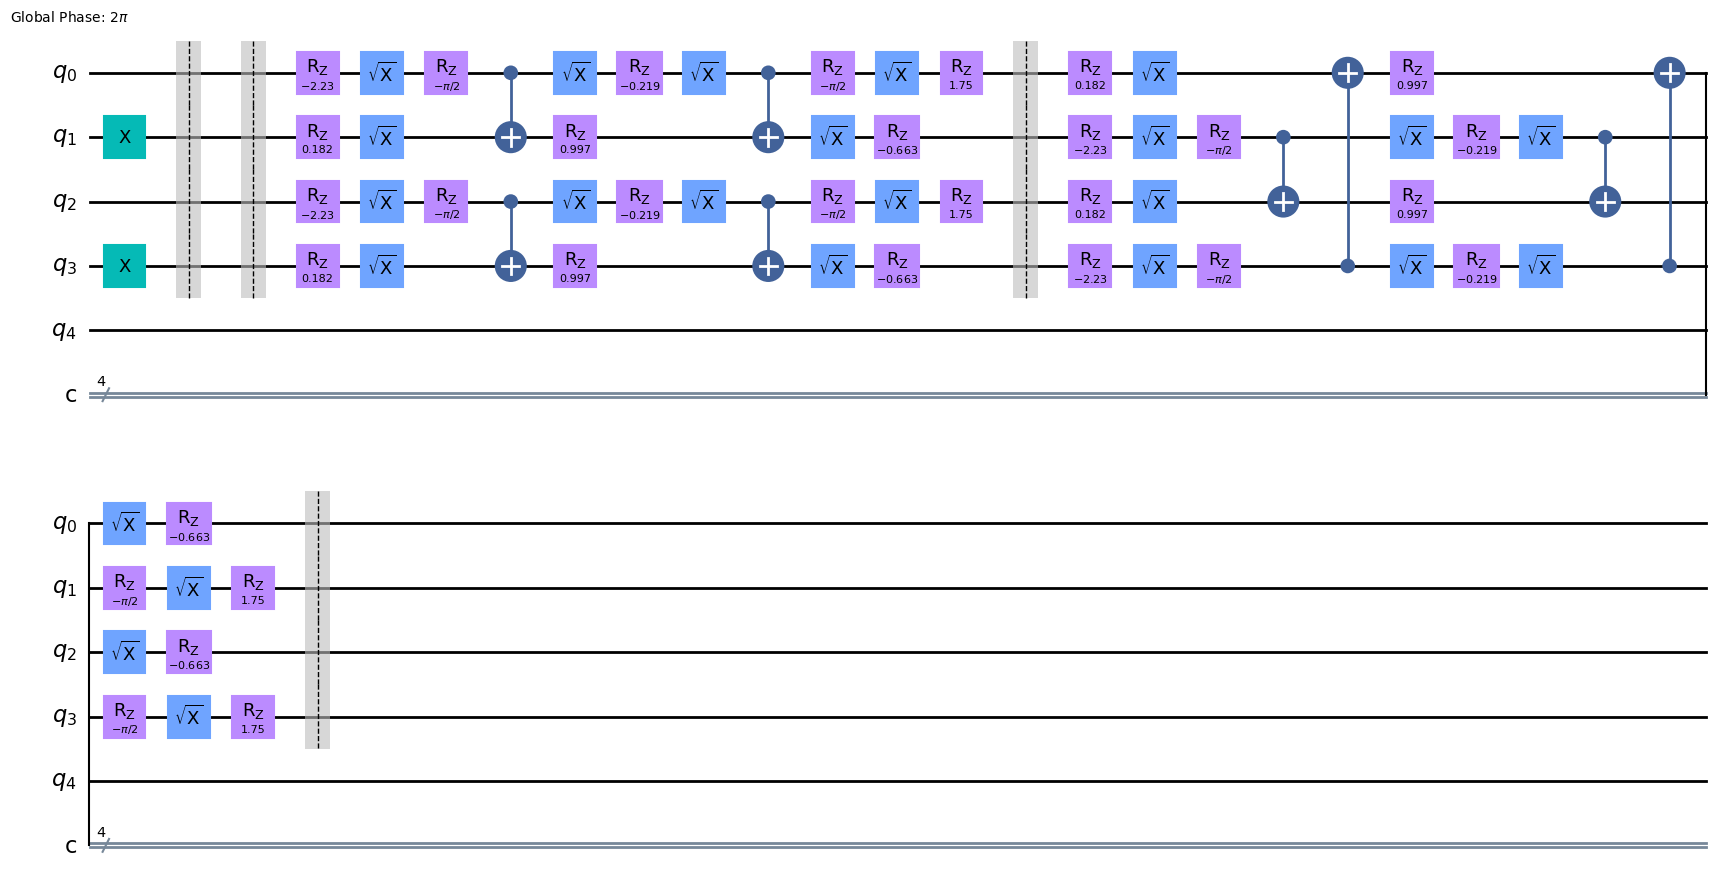

In [5]:
#build circuit    
n=4
qc = QuantumCircuit(n+1,4)

#v0=(1,0,0,0)#TODO:CHOOSE INITIAL STATE AND INIT
#init = U(1,1,1)@v0
#init = init.tolist()
QuantumCircuit.initialize(qc,'01010',[0,1,2,3,4])

qc.barrier(range(n))
qc.barrier(range(n))
#SPECIFY PARAMETERS
A=1;T=1;G=1;
matrix = U(A,T,G)

layers = 1
m=0;

while m < layers:
    i=0;j=0;    
    #even layer
    while i < n/2:
        qc.unitary(matrix, [2*i,2*i+1])
        i+=1;
    qc.barrier(range(n))
    #odd layer
    while j < n/2:
        
        if j == (n/2 - 1):
            qc.unitary(matrix,[2*j+1,0])
        else:
            qc.unitary(matrix, [2*j+1,2*j+2])
        
        j+=1;
    qc.barrier(range(n))
    
    m+=1

    


basis_gates=['cx', 'id', 'rz', 'x', 'sx']  # specify native gates here, I tried introducing rzx to realise quicker CNOT but
                                           # it doesn't compile


#qc.z(0)
#qc.z(3)
#qc.measure(0,0)
#qc.measure(3,1)
qcc = transpile(qc, basis_gates=basis_gates, optimization_level=3)

#qcc.measure(range(4),range(4))
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')
#Plot circuit
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

qcc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


In [11]:
#critical point 

# Simulate the circuit

shots = 8000  # Adjust the number of measurement shots as needed
job = execute(qcc, backend, shots=shots)
result = job.result()
counts = result.get_counts(qcc)
print(counts)
#raise KeyboardInterrupt
# Compute the expectation value <σ_z>
#expectation_value = 0
#for outcome, count in counts.items():
#    # Convert '0' outcome to +1 and '1' outcome to -1
#    expectation_value += count * (1 if outcome == '0' else -1)
#
#expectation_value /= shots
#print(expectation_value)

{'01': 148, '10': 306, '00': 301, '11': 269}
-1.0


In [12]:
counts.items()

dict_items([('01', 148), ('10', 306), ('00', 301), ('11', 269)])

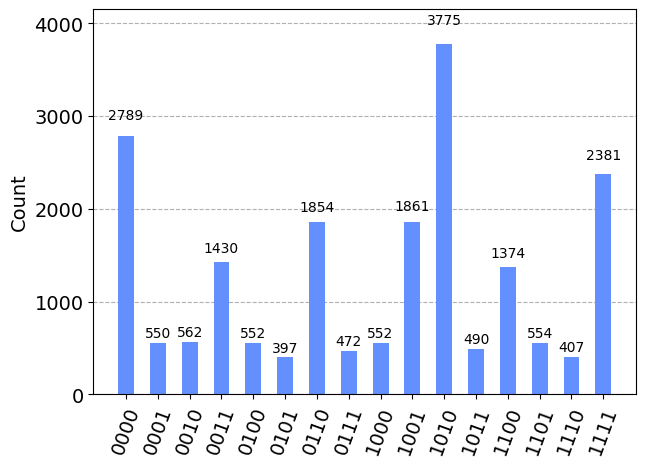

In [20]:
#backend = Aer.get_backend('statevector_simulator') # gets backend for simulation
job = backend.run(qcc) #creates quantum program for exec
#result = job.result()  #access result of sim
#simulator = Aer.get_backend('qasm_simulator')
#job = execute(qcc, simulator, shots=8000)  # Simulate the circuit 1024 times
shots = 20000  # Change this to the number of shots you want
job = execute(qcc, backend, shots=shots)
result = job.result()
counts = result.get_counts(qcc)  # Get the measurement counts

#outputstate = result.get_statevector(qcc, decimals=3)  #access statevector from results file
#state = Statevector(qcc)



plot_histogram(counts)          #histogram of results' statistics


#plot_state_city(outputstate)   #nice visualization 3D

In [ ]:
# QST Experiment
qstexp1 = StateTomography(qcc)
qstdata1 = qstexp1.run(backend, shots=8000, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

#fitted state extraction
final_state = qstdata1.analysis_results("state")
density=np.asarray(final_state.value)
print(density[0,0])
#A.append(density([0,0]))
plt.plot(density[0,0],'x')

In [ ]:
#qc.decompose(reps=2).draw(output='mpl',style={'displaycolor':dispcolors}) #displays decomposition of circuit
backend = Aer.get_backend('statevector_simulator') # gets backend for simulation
job = backend.run(qcc) #creates quantum program for exec
result = job.result()  #access result of sim
#status = job.status()  #check status of sim 
outputstate = result.get_statevector(qcc, decimals=3)  #access statevector from results file
qobj = assemble(qc)#Assemble circuit into a Qobj that can be run

####
from qiskit.circuit import Parameter  #how to define parameter and bind it to range 
theta = Parameter('θ')
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]  #this creates an array of circuits with different thetas
####VISUALIZATION######

from qiskit.visualization import plot_histogram
plot_histogram(counts)          #histogram of results' statistics

from qiskit.visualization import plot_state_city
plot_state_city(outputstate)   #nice visualization 3D

In [ ]:
circ = QuantumCircuit(4)
matrix = U(1,1,1)
qc.unitary(matrix,[0,1])
qc.unitary(matrix,[2,3])